In [41]:
import cv2
import joblib
import os
import time
from os import walk
from skimage import feature
import imageio
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy import ndimage as ndi
import pickle
import pandas as pd
from sklearn.decomposition import PCA
# from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay


In [5]:
  
def segm_6(img):
#     blur the img then turn it into gray scale
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    return gray

def segm_9(img):
    # Convert BGR to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    # Split HSV image into separate channels
    _, _, B_channel = cv2.split(hsv_img)
    _, trr2 = cv2.threshold(
        B_channel, 1, 1.0, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    trr2 = ndi.binary_fill_holes(trr2).astype(np.uint8)
    
    contours ,_= cv2.findContours(trr2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    maxcontour = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(maxcontour)
    crop = img[y:y+h,x:x+w]
    masked_data = cv2.bitwise_and(crop, crop,mask = trr2[y:y+h,x:x+w])
    masked_data = cv2.resize(masked_data,(128*2,64*2))
    return cv2.cvtColor(masked_data, cv2.COLOR_BGR2GRAY)
  
  
def make_to_left(img):
  a = img.sum(axis=0)
  a = a / a.max()
  if(a[:int(len(a)//8)].sum() < a[int(len(a)*7//8):].sum()):
    # flip the image
    return cv2.flip(img, 1)
  return img

def preprocess(img):

  img = make_to_left(img)
  img = segm_9(img)
  return img



In [127]:


def ImageSegmentation():
    path_IS = r"./test_test_seg"
    if not os.path.exists(path_IS):
        os.makedirs(path_IS)
    lstFiles = []  # nombre de imagenes
    path = r"./New folder"

    for (path, _, archivos) in walk(path):
        # print(path)
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG" or ext == ".jpg" or ext == ".PNG" or ext == ".png"  ):
                label = path.split("\\")[-1]
                # print(label)
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = label + "_" + nomArch + ext
                # print(path + "/" + nomArch + ext)
                image = cv2.imread(direc)

                if image is not None:
                    image = cv2.resize(image, (461, 260))
                    # # cv2.imshow("ss",image)
                    # image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                    #                               cv2.THRESH_BINARY, 11, 2)
                    # image = cv2.GaussianBlur(image, (5, 5), 0)

                    # image = np.sum(image, axis= 1)
                    # print(image.shape())
                    # holesimg = preprocess(direc)
                    # plt.imshow(image,'gray')
                    # # plt.title(titles[i])
                    # plt.xticks([]),plt.yticks([])
                    # plt.show()
                    image = preprocess(image)
                    imageio.imwrite(os.path.join(path_IS, name), image)


ImageSegmentation()


In [132]:
# def HOG_oper(img_binary):
#     (H) = feature.hog(img_binary, orientations=9, pixels_per_cell=(16,16),
#                                   cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",channel_axis=-1) 
#     pca = joblib.load(r"./Feature-Extraction/pca.pkl") #PCA(0.97).fit_transform(H.reshape(1, -1))
#     components = pca.transform(H.reshape(1, -1))
#     # joblib.dump(pca, r"./Feature-Extraction/pca.pkl")
#     return components
from tqdm import tqdm
def HOG_PCA():
    data_HOG = pd.read_csv(r'./Feature-Extraction/last_hog.txt', sep=',', header=None)
    file2 = open(r"./Feature-Extraction/last_hog_PCA.txt", "w")
    name_HOG = data_HOG.iloc[:, 0]
    value_HOG = data_HOG.iloc[:, 1:-1]
    tag_HOG = data_HOG.iloc[:, -1] # 0,1,2,3,4,5
    print("PCA")
    pca = PCA(0.97).fit(value_HOG)
    joblib.dump(pca, r"./Feature-Extraction/last_hog_pca.pkl")
    
    components = pca.transform(value_HOG)
    print(components.shape)
    for row in tqdm(range(len(components))):
        file2.write(name_HOG[row])
        for colm in range(len(components[row])):
            file2.write(",%.4f" %components[row][colm])
        file2.write(",%s" %tag_HOG[row] + "\n")
    file2.close()

def HOG():
    print("HOG\n")
    file  = open(r"./Feature-Extraction/last_hog.txt", "w")
    lstFiles = []  # nombre de imagenes
    path = r"./test_seg"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                # print(nomArch + ext)
                img_binary = cv2.imread(direc,0)
                
                (H) = feature.hog(img_binary, orientations=9,  pixels_per_cell=(16, 16),
                                  cells_per_block=(3, 3) ,block_norm='L2-Hys',feature_vector=True)#,channel_axis=-1)  # ,visualize=True
                file.write(name)
                for item in range(len(H)):
                    file.write(",%.3f" % H[item])
                file.write("," + name[0] + "\n")
    file.close()
    
HOG()
HOG_PCA()


HOG

PCA
(1841, 706)


100%|██████████| 1841/1841 [00:03<00:00, 460.35it/s]


In [149]:
pca_transformer = joblib.load("./Feature-Extraction/last_hog_pca.pkl")

labels, features =[], []
for imagePath in os.listdir("test_seg"):
    # extract the label from the image path
    # we can get the label from the image name as the label is the first char of the image name
    # for example, the label of image 1_1.jpg is 1
    labels.append((int)(imagePath.split(os.path.sep)[-1][0]))
    
    # load the image, convert it to grayscale, and detect
    # edges in it
    image = cv2.imread("test_seg/" + imagePath,0)
    
    # extract Histogram of Oriented Gradients from the
    # test image
    # display the original image
    # if the image exists, display it and count the number of images
    if image is not None:
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # image = cv2.resize(image, (461, 260))
        # image = preprocess(image)
        (H) = feature.hog(image, orientations=9,  pixels_per_cell=(16, 16),
                                  cells_per_block=(3, 3) ,block_norm='L2-Hys',feature_vector=True)#,channel_axis=-1)  # ,visualize=True

        # components = pca_transformer.transform(H.reshape(1, -1))
        features.append(H)
        # print(components.shape)


In [49]:
print(len(labels))
print(len(features))

1841
1841


In [153]:
trainingData, testData, trainingLabels, testLabels = train_test_split(features, labels, test_size=0.2, random_state=42)
trainingData = np.asarray(trainingData)
trainingData.shape
# testData = np.asarray(testData)

# nsamples_test, nx_test, ny_test = testData.shape
# testData = testData.reshape((nsamples_test,nx_test*ny_test))

(1472, 6804)

In [155]:
model = SVC(kernel='poly')#, gamma=0.1, C=10)
# trainingData, testData, trainingLabels, testLabels = train_test_split(features, labels, test_size=0.2, random_state=42)

# trainingData = np.asarray(trainingData)

# nsamples, nx, ny = trainingData.shape
# trainingData = trainingData.reshape((nsamples,nx*ny))
model.fit(trainingData, trainingLabels)
f = open("last_hog_clf.pkl", "wb") # wb = write binary
f.write(pickle.dumps(model))
f.close()




In [161]:
model = joblib.load("./last_hog_clf.pkl")
pca_transformer = joblib.load("./Feature-Extraction/last_hog_pca.pkl")
test_labels, test_times = [], []

count_right = 0
# for imagePath in os.listdir(direc):
for i, image in enumerate(testData):


    if image is not None:
        start = time.time()

        label = model.predict(image.reshape(1, -1))
        end = time.time() - start
        if label == testLabels[i]:
            count_right += 1
        test_labels.append(label)
        test_times.append(end)



with open(r'result_labels.txt', 'w') as fp:
    for item in test_labels:
        # write each item on a new line
        fp.write("%s\n" % item[0])
with open(r'./result_times.txt', 'w') as fp:
    fp.write("\n".join(str(item) for item in test_times))
    
print(count_right/len(testLabels))


0.8482384823848238


Confusion matrix, without normalization
[[51  0  0  0  1  0]
 [ 2 69  2  1  0  0]
 [ 0  3 53  5  0  0]
 [ 0  0  7 38  9  2]
 [ 1  0  7 13 39  2]
 [ 0  0  0  3  5 56]]
Normalized confusion matrix
[[0.98076923 0.         0.         0.         0.01923077 0.        ]
 [0.02702703 0.93243243 0.02702703 0.01351351 0.         0.        ]
 [0.         0.04918033 0.86885246 0.08196721 0.         0.        ]
 [0.         0.         0.125      0.67857143 0.16071429 0.03571429]
 [0.01612903 0.         0.11290323 0.20967742 0.62903226 0.03225806]
 [0.         0.         0.         0.046875   0.078125   0.875     ]]


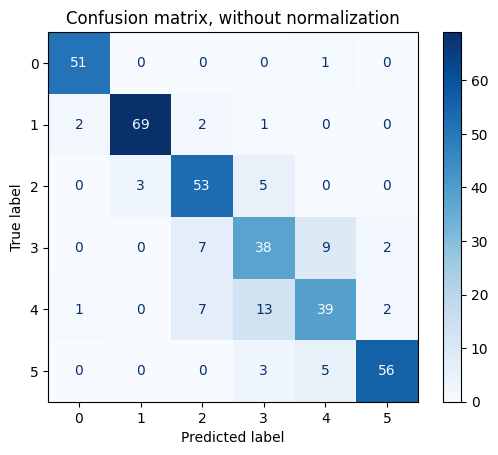

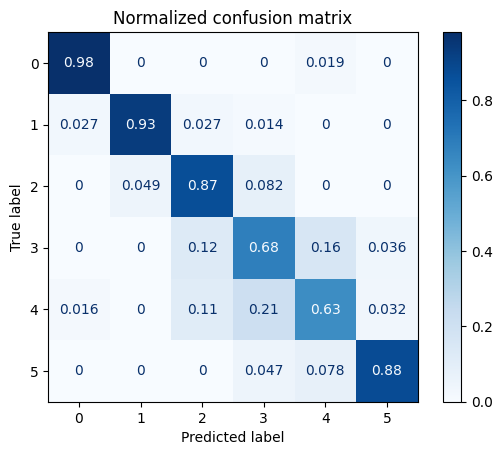

In [63]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        testData,
        testLabels,
        display_labels=['0','1','2','3','4','5'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


In [173]:
labels2, predicted_labels =[], []
for imagePath in os.listdir("test_test_seg"):
    # extract the label from the image path
    # we can get the label from the image name as the label is the first char of the image name
    # for example, the label of image 1_1.jpg is 1
    labels2.append((int)(imagePath.split(os.path.sep)[-1][0]))
    
    # load the image, convert it to grayscale, and detect
    # edges in it
    image = cv2.imread("test_test_seg/" + imagePath)
    
    # extract Histogram of Oriented Gradients from the
    # test image
    # display the original image
    # if the image exists, display it and count the number of images
    if image is not None:      
        (H) = feature.hog(image, orientations=9,  pixels_per_cell=(16, 16),
                                  cells_per_block=(3, 3) ,block_norm='L2-Hys',feature_vector=True,channel_axis=-1)  # ,visualize=True
        predicted_label = model.predict(H.reshape(1, -1))
        predicted_labels.append(predicted_label[0])


SyntaxError: invalid syntax (896203790.py, line 21)

In [172]:
predicted_labels = np.asarray(predicted_labels)
labels2 = np.asarray(labels2)

print(len(predicted_labels[predicted_labels != labels2]) / len(labels2))
# print(labels2)

0.6542056074766355


In [87]:
labels2 = np.asanyarray(labels2)
predicted_labels = np.asanyarray(predicted_labels)
# predicted_labels = predicted_labels.reshape(1,-1)
predicted_labels = [x[0] for x in predicted_labels]
predicted_labels = np.asanyarray(predicted_labels)

print(predicted_labels.shape)


IndexError: invalid index to scalar variable.

In [94]:
wrong = len(labels2[labels2 != predicted_labels])
print(1-wrong/107)

0.3271028037383178


In [128]:
# !rm -rf /content/kaggle/dataset/dataset
def plt_t(title, img, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

In [159]:
kamal_labels_labels_bgd = pd.read_csv("./kamal_labels.txt", header= None)#, delimiter='\n')

# print(len(kamal_labels_labels_bgd))
kamal_labels_labels_bgd = np.asarray(kamal_labels_labels_bgd.values)

In [158]:
kamal_labels = []
i = 0
for imagePath in os.listdir("kamal"):

    image = cv2.imread("kamal/" + imagePath)

    if image is not None:
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # image = cv2.resize(image, (461, 260))
        image = preprocess(image)
        # plt_t('a', image)
        # print(image.shape)
        (H, vis) = feature.hog(image, orientations=9,  pixels_per_cell=(16, 16),
                          cells_per_block=(3, 3), block_norm='L2-Hys', feature_vector=True, visualize = True)

        # components = pca_transformer.transform(H.reshape(1, -1))
        # kamal_labels.append(model.predict(components)[0])
        label_k = model.predict(H.reshape(1, -1))[0]
        # if label_k != kamal_labels_labels_bgd[i]:
            # plt_t(' ', image, cmap='gray')
            # plt_t(' ', vis, cmap='gray')
        i += 1
        # features.append(components)
        # print(components.shape)


In [142]:

# print(kamal_labels_labels_bgd)

# print(kamal_labels_labels_bgd.shape)
# kamal_labels = np.asarray(kamal_labels)

# print(kamal_labels)
# print(kamal_labels.shape)


In [160]:

# kamal_labels = np.asarray(kamal_labels)
# kamal_labels_labels_bgd = [x[0] for x in kamal_labels_labels_bgd]
# kamal_labels_labels_bgd = np.asarray(kamal_labels_labels_bgd)
# print(kamal_labels.shape)
# print(kamal_labels_labels_bgd.shape)

print(len(kamal_labels_labels_bgd[kamal_labels_labels_bgd != kamal_labels ]) )

0
